# Calibration scores

how to deal with different threshold?
-> scale confidences according to threshold range, such that confidences are always between 0.5 - 1.
E.g. if threshold = 0.2, confidence will be in range 0.2 - 1 -> rescale them to be in 0.5 - 1

TODO: calculate ECE per class
TODO: calculate per cluster scores - entropy-based score proposed in https://arxiv.org/pdf/1911.13273.pdf
TODO: research other ways to calculate per cluster scores

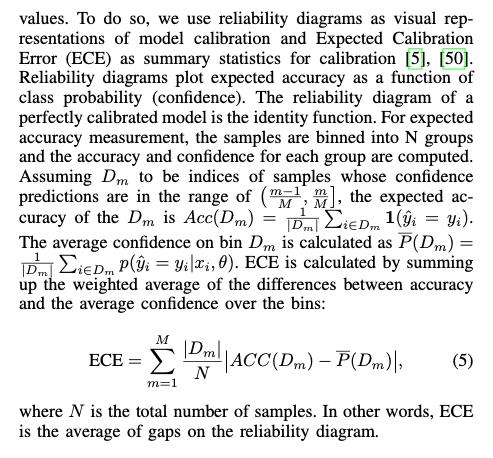

In [47]:
from meld_graph.evaluation import load_prediction, Evaluator
from meld_graph.experiment import Experiment
from meld_graph.dataset import GraphDataset
import h5py
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## MC dropout

In [2]:
model_name = '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all'
exp = Experiment.from_folder(model_name)
features = exp.data_parameters['features']
cohort = exp.cohort


Initialised Experiment 23-08-30_IGKW_object_save_final/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all


In [3]:
# get dataset - and create Evaluator from this
train_ids, val_ids, test_ids = exp.get_train_val_test_ids()
dataset = GraphDataset(test_ids[:10], exp.cohort, exp.data_parameters, mode="test")

Loading and preprocessing test data
Z-scoring data for MELD_H2_15T_FCD_0001
Z-scoring data for MELD_H2_15T_FCD_0003
Z-scoring data for MELD_H2_15T_FCD_0005
Z-scoring data for MELD_H2_15T_FCD_0007
Z-scoring data for MELD_H2_15T_FCD_0008
Z-scoring data for MELD_H2_15T_FCD_0009
Z-scoring data for MELD_H2_15T_FCD_0014
Z-scoring data for MELD_H2_15T_FCD_0015
Z-scoring data for MELD_H2_15T_FCD_0016
Z-scoring data for MELD_H2_15T_FCD_0020


In [4]:
eva = Evaluator(exp, dataset=dataset, model_name='ensemble_best_model.pt', checkpoint_path=exp.experiment_path)

Evaluation test, min area threshold=100, threshold sigmoid(ymin=0.05, ymax=0.3, k=1.0, m=0.05)
Creating model
Creating ensemble model
Loading ensemble model weights from checkpoint /rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all/ensemble_best_model.pt


In [5]:
eva.enable_mc_dropout(eva, p=0.5, n=10)
#disable_mc_dropout(eva)

Predicting model with droput (p=0.5, n=10)


In [15]:
eva.load_predict_data()

loading data and predicting model
saving prediction for MELD_H2_15T_FCD_0001
saving distance_map for MELD_H2_15T_FCD_0001
saving prediction for MELD_H2_15T_FCD_0003
saving distance_map for MELD_H2_15T_FCD_0003
saving prediction for MELD_H2_15T_FCD_0005
saving distance_map for MELD_H2_15T_FCD_0005
saving prediction for MELD_H2_15T_FCD_0007
saving distance_map for MELD_H2_15T_FCD_0007
saving prediction for MELD_H2_15T_FCD_0008
saving distance_map for MELD_H2_15T_FCD_0008
saving prediction for MELD_H2_15T_FCD_0009
saving distance_map for MELD_H2_15T_FCD_0009
saving prediction for MELD_H2_15T_FCD_0014
saving distance_map for MELD_H2_15T_FCD_0014
saving prediction for MELD_H2_15T_FCD_0015
saving distance_map for MELD_H2_15T_FCD_0015
saving prediction for MELD_H2_15T_FCD_0016
saving distance_map for MELD_H2_15T_FCD_0016
saving prediction for MELD_H2_15T_FCD_0020
saving distance_map for MELD_H2_15T_FCD_0020


In [19]:
eva.threshold_and_cluster()

saving prediction_clustered for MELD_H2_15T_FCD_0001
saving prediction_clustered for MELD_H2_15T_FCD_0003
saving prediction_clustered for MELD_H2_15T_FCD_0005
saving prediction_clustered for MELD_H2_15T_FCD_0007
saving prediction_clustered for MELD_H2_15T_FCD_0008
saving prediction_clustered for MELD_H2_15T_FCD_0009
saving prediction_clustered for MELD_H2_15T_FCD_0014
saving prediction_clustered for MELD_H2_15T_FCD_0015
saving prediction_clustered for MELD_H2_15T_FCD_0016
saving prediction_clustered for MELD_H2_15T_FCD_0020


## Calibration scores

In [45]:
def get_lesion(subjects, cohort, results_dict=None):
    if results_dict is None:
        results_dict = {}
    for subj_id in subjects:
        if subj_id not in results_dict.keys():
            results_dict[subj_id] = {}
        subj = MeldSubject(subj_id, cohort=cohort)
        results_dict[subj_id]['lesion'] = np.concatenate([
            np.ceil(subj.load_feature_values(".on_lh.lesion.mgh", hemi='lh')).astype(int)[cohort.cortex_mask],
            np.ceil(subj.load_feature_values(".on_lh.lesion.mgh", hemi='rh')).astype(int)[cohort.cortex_mask]])
    return results_dict


def get_confidence(eva, subjects, cohort, threshold=0.5):
    """
    Return pixel-wise confidence for a prediction hdf5 file and a list of subjects.
    Returned dict will contain for each subject:
        prediction: the softmaxed prediction score
        lesion: groundtruth lesion masks
        confidence: the prediction score for the prediced class
        
    Args:
        eva: Evaluator object
        subjects: list of subject ids to compute confidence for
        cohort: MELDCohort
        threshold: threshold of lesional predictions
    """
    results_dict = get_lesion(subjects, cohort)
    
    for subj_id in subjects:
        if subj_id not in results_dict.keys():
            results_dict[subj_id] = {}
            
        subj_results_dict = eva.load_data_from_file(subj_id, keys=['result','cluster_thresholded'], 
                        save_prediction_suffix='_dropout') # TODO delete save_p[rediction suffix]
        
        # threshold and confidence is only used for overall confidence, plotting is done with confidence_lesion
        thresholded_prediction = (subj_results_dict['cluster_thresholded'] > 0).astype(int)
        confidence = thresholded_prediction * subj_results_dict['result'] + (1-thresholded_prediction) * (1-subj_results_dict['result'])
        results_dict[subj_id]['prediction'] = thresholded_prediction
        results_dict[subj_id]['confidence'] = confidence
        results_dict[subj_id]['confidence_lesion'] = subj_results_dict['result']
        results_dict[subj_id]['confidence_nonlesion'] = 1 - subj_results_dict['result']
        # previous confidence scaling, depending on prediction
        #confidence = (prediction > threshold)*((prediction-min1)/(1-min1)) \
        #            +(prediction <= threshold)*((1-prediction-min2)/(1-min2))
        # TODO scaling is wrong somehow, but not sure how!
        #confidence = lesion*((prediction-min1)/(1-min1)) \
        #            +(1-lesion)*((1-prediction-min2)/(1-min2))
        #results_dict[subj_id]['confidence_scaled'] = confidence
    return results_dict


def calibration_plot(results_dict, n_bins=10, confidence='confidence_lesion'):
    """
    calculate ECE as described in literature
    calclulate calibration plot as calculated by sklearn.calibration
    """
    # sort all results in bins according to confidence score
    bins = np.linspace(0,1,n_bins+1)
    binned_prediction = {bin_idx: np.array([]) for bin_idx in range(len(bins[:-1]))}
    binned_confidence = {bin_idx: np.array([]) for bin_idx in range(len(bins[:-1]))}
    binned_lesion = {bin_idx: np.array([]) for bin_idx in range(len(bins[:-1]))}
    for subj_results in results_dict.values():
        for bin_idx in binned_prediction.keys():
            bin_min = bins[bin_idx]
            bin_max = bins[bin_idx+1]
            # get idx of all vertices in current bin (according to confidence)
            mask = (subj_results[confidence] > bin_min) & (subj_results[confidence] <= bin_max)
            #lesion_mask = subj_results['lesion']
            binned_prediction[bin_idx] = np.concatenate([binned_prediction[bin_idx], subj_results['prediction'][mask]])
            binned_lesion[bin_idx] = np.concatenate([binned_lesion[bin_idx], subj_results['lesion'][mask]])
            binned_confidence[bin_idx] = np.concatenate([binned_confidence[bin_idx], subj_results[confidence][mask]])    
    # calculate accuracy as frequency of correct labels in each bin
    freq = []
    acc = []
    conf = []
    n = []
    for bin_idx in binned_prediction.keys():
        if confidence == 'confidence_lesion':
            freq.append(binned_lesion[bin_idx].sum()/len(binned_lesion[bin_idx]))
        if confidence == 'confidence_nonlesion':
            freq.append(1 - binned_lesion[bin_idx].sum()/len(binned_lesion[bin_idx]))
        conf.append(binned_confidence[bin_idx].sum()/len(binned_lesion[bin_idx]))
        acc.append((binned_prediction[bin_idx] == binned_lesion[bin_idx]).sum() / len(binned_lesion[bin_idx]))
        n.append(len(binned_prediction[bin_idx]) / sum([len(binned_prediction[i]) for i in binned_prediction.keys()]))
    # NOTE also calculate ECE as freq - conf, instead of using acc
    ece = (np.abs(np.array(freq) - np.array(conf))*np.array(n)).sum()
    print('ECE: ', ece)
        
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(bins[:-1] + (bins[1:]-bins[:-1])/2, freq, 'o-')
    ax.bar(bins[:-1] + (bins[1:]-bins[:-1])/2, n, width=0.05, color='black', alpha=0.5)
    ax.set_xlabel(confidence)
    ax.set_ylabel('frequency of label')
    ax.set_title('ECE: {}'.format(ece))
    return freq, acc, conf, n


## Single vertex scores

Initialised Experiment 23-08-30_IGKW_object_save_final/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all


Loading and preprocessing test data
Z-scoring data for MELD_H2_15T_FCD_0001
Evaluation test, min area threshold=100, threshold sigmoid(ymin=0.05, ymax=0.3, k=1.0, m=0.05)


['MELD_H2_15T_FCD_0001', 'MELD_H2_15T_FCD_0003', 'MELD_H2_15T_FCD_0005', 'MELD_H2_15T_FCD_0007', 'MELD_H2_15T_FCD_0008', 'MELD_H2_15T_FCD_0009', 'MELD_H2_15T_FCD_0014', 'MELD_H2_15T_FCD_0015', 'MELD_H2_15T_FCD_0016', 'MELD_H2_15T_FCD_0020']
ECE:  0.003493281756012943
[0.004494328536140383, 0.07046959104126709, 0.09154570919276801, 0.11959692389286661, 0.19778699861687413, 0.290263319044703, 0.346514745308311, 0.45350404312668463, 0.6317135549872123, 0.5682517960998974] [0.990665015055259, 0.36373198044917404, 0.3469569646040234, 0.11959692389286661, 0.19778699861687413, 0.290263319044703, 0.346514745308311, 0.45350404312668463, 0.6317135549872123, 0.5682517960998974] [0.003221827436316353, 0.14179244961547857, 0.2460351061860447, 0.34444036156737307, 0.44410535113335536, 0.5495560206450061, 0.6499626285349076, 0.7502443515708183, 0.8505525834039044, 0.967615841840417] [0.986707805203469, 0.005501286572000381, 0.0026732107119031736, 0.0012835087337136322, 0.0007382472668854066, 0.000555

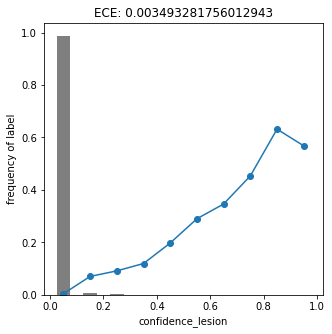

In [46]:
# model paths
model_path = '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all'
suffix = "_dropout"
model_name = 'ensemble_best_model.pt'

# load experiment
exp = Experiment.from_folder(model_path)
features = exp.data_parameters['features']
cohort = exp.cohort

# load evaluator with small dataset (don't need this dataset, but want to keep loading time down)
train_ids, val_ids, test_ids = exp.get_train_val_test_ids()
dataset = GraphDataset(test_ids[:1], exp.cohort, exp.data_parameters, mode="test")
eva = Evaluator(exp, dataset=dataset, model_name=model_name, thresh_and_clust=True)  
# thresh_and_clust flag needed such that loads sigmoid parameters from file

prediction_fname = os.path.join(model_path, f'results/predictions{suffix}.hdf5')
subjects = list(h5py.File(prediction_fname, 'r').keys())
print(subjects)

results_dict = get_confidence(eva, subjects[:100], cohort)

freq, acc, conf, n = calibration_plot(results_dict)
print(freq, acc, conf, n)

## Clustered scores - TODO adapt to new clusteres & threshold - can use saved clusters in hdf5

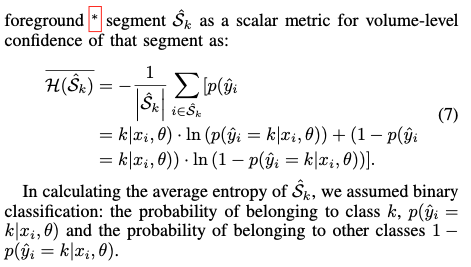

In [22]:
import scipy
def cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0):
    """cluster predictions and threshold based on min_area_threshold
    Args:
        mask: boolean mask of the per-vertex lesion predictions to cluster"""
    n_comp, labels = scipy.sparse.csgraph.connected_components(cohort.adj_mat[mask][:, mask])
    islands = np.zeros(len(mask))
    # only include islands larger than minimum size.
    for island_index in np.arange(n_comp):
        include_vec = labels == island_index
        size = np.sum(include_vec)
        if size >= min_area_threshold:
            island_count += 1
            #print(island_count)
            island_mask = mask.copy()
            island_mask[mask] = include_vec
            islands[island_mask] = island_count
    return islands
def load_prediction(subject,hdf5,dset='prediction'):
    results={}
    with h5py.File(hdf5, "r") as f:
        for hemi in ['lh','rh']:
            results[hemi] = f[subject][hemi][dset][:]
    return results
# define sigmoid functions to find threshold in function of min distance
def sigmoid(x, k=2, m=0.5, ymin=0.03, ymax=0.5):
    """
    Inverse sigmoid function with fixed endpoints ymin and ymax, variable midpoint m and slope k.
    Function has the following properties: f(0)=ymax, f(1)=ymin (except for k=0, where f(x)=ymin)
    Shifting the midpoint will squeeze the function in the range 0,2*midpoint, and set all values beyond to ymin.
    Args:
        x: input values that should be transformed
        k: slope
        m: midpoint
        ymin: min value
        ymax: max value
    """
    xmax = m*2
    # inverse sigmoid function with fixed endpoints and variable slope k
    # k = 0 defaults to ymin
    if k == 0:
        return np.ones_like(x)*ymin
    eps = 1e-15
    res = 1 / (1 + (1/(x/xmax+eps)-1)**(-k))
    # scale y range
    scaled_res = res * (ymax - ymin) + ymin
    # clip values of x > xmax to ymin
    scaled_res[x > xmax] = ymin
    return scaled_res

def cluster_predictions(results_dict, cohort):
    # cluster predictions
    for subj in results_dict.keys():
        hemis = cohort.split_hemispheres(results_dict[subj]['prediction'])
        clusters = []
        min_cluster = 0
        for key in hemis.keys():
            clus = cluster_and_area_threshold(cohort, hemis[key] > 0)[cohort.cortex_mask]
            clus[clus!=0] = clus[clus!=0]+min_cluster
            #print(np.unique(clus))
            min_cluster = clus.max()
            clusters.append(clus)
        clusters = np.concatenate(clusters)
        results_dict[subj]['clusters'] = clusters
    return results_dict

In [23]:
# ensemble
model_name = '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all'
suffix = "_dropout"

exp = Experiment.from_folder(model_name)
features = exp.data_parameters['features']
cohort = exp.cohort

prediction_fname = os.path.join(model_name, f'results/predictions{suffix}.hdf5')
subjects = list(h5py.File(prediction_fname, 'r').keys())

threshold = 0.5
results_dict = get_confidence(subjects, prediction_fname, cohort, threshold=threshold)
results_dict = cluster_predictions(results_dict, cohort)

Initialised Experiment 23-08-30_IGKW_object_save_final/s_0


/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/23-08-30_IGKW_object_save_final/s_0/fold_all


ECE:  0.003493281756012943


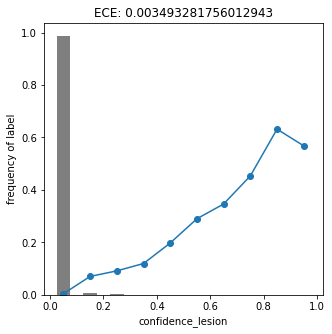

In [24]:
freq, acc, conf, n = calibration_plot(results_dict)

In [25]:
# calculate mean confidence per cluster & whether it was detected
per_cluster_confidence = []
per_cluster_label = []
for subj in results_dict.keys():
    for i in range(int(results_dict[subj]['clusters'].max())):
        if i == 0:
            # don't do anything for background class
            continue
        # for foreground cluster, calculate mean confidence
        mask = results_dict[subj]['clusters'] == i
        per_cluster_confidence.append(results_dict[subj]['confidence_lesion'][mask].mean())
        per_cluster_label.append(results_dict[subj]['lesion'][mask].max())

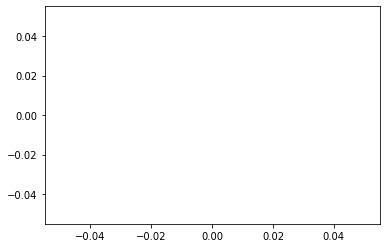

In [26]:
plt.plot(per_cluster_label, per_cluster_confidence, 'o')

In [170]:
def cluster_calibration_plot(confidence, label, n_bins=10):
    """
    calculate ECE as described in literature
    calclulate calibration plot as calculated by sklearn.calibration
    """
    # sort all results in bins according to confidence score
    bins = np.linspace(0,1,n_bins+1)
    binned_confidence = {bin_idx: np.array([]) for bin_idx in range(len(bins[:-1]))}
    binned_lesion = {bin_idx: np.array([]) for bin_idx in range(len(bins[:-1]))}
    for bin_idx in binned_lesion.keys():
        bin_min = bins[bin_idx]
        bin_max = bins[bin_idx+1]
        # get idx of all vertices in current bin (according to confidence)
        mask = (confidence > bin_min) & (confidence <= bin_max)
        binned_lesion[bin_idx] = np.concatenate([binned_lesion[bin_idx], label[mask]])
        binned_confidence[bin_idx] = np.concatenate([binned_confidence[bin_idx], confidence[mask]])    
    # calculate accuracy as frequency of correct labels in each bin
    freq = []
    acc = []
    conf = []
    n = []
    for bin_idx in binned_lesion.keys():
        freq.append(binned_lesion[bin_idx].sum()/len(binned_lesion[bin_idx]))
        conf.append(binned_confidence[bin_idx].sum()/len(binned_lesion[bin_idx]))
        #acc.append((binned_prediction[bin_idx] == binned_lesion[bin_idx]).sum() / len(binned_lesion[bin_idx]))
        n.append(len(binned_confidence[bin_idx]) / sum([len(binned_confidence[i]) for i in binned_confidence.keys()]))
    # NOTE also calculate ECE as freq - conf, instead of using acc
    ece = np.nansum(np.abs(np.array(freq) - np.array(conf))*np.array(n))
    print('ECE: ', ece)
        
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(bins[:-1] + (bins[1:]-bins[:-1])/2, freq, 'o-')
    ax.bar(bins[:-1] + (bins[1:]-bins[:-1])/2, n, width=0.05, color='black', alpha=0.5)
    ax.set_xlabel('confidence')
    ax.set_ylabel('frequency of label')
    ax.set_title('ECE: {}'.format(ece))
    return freq, acc, conf, n

ECE:  0.3010179613317762


/tmp/ipykernel_3373700/1063260543.py:23: RuntimeWarning: invalid value encountered in double_scalars
  freq.append(binned_lesion[bin_idx].sum()/len(binned_lesion[bin_idx]))
/tmp/ipykernel_3373700/1063260543.py:24: RuntimeWarning: invalid value encountered in double_scalars
  conf.append(binned_confidence[bin_idx].sum()/len(binned_lesion[bin_idx]))


([nan,
  nan,
  nan,
  nan,
  nan,
  0.16326530612244897,
  0.6153846153846154,
  1.0,
  1.0,
  nan],
 [],
 [nan,
  nan,
  nan,
  nan,
  nan,
  0.5105983773056342,
  0.6539184084305396,
  0.7571890733458779,
  0.8205593377351761,
  nan],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.7777777777777778,
  0.10317460317460317,
  0.0873015873015873,
  0.031746031746031744,
  0.0])

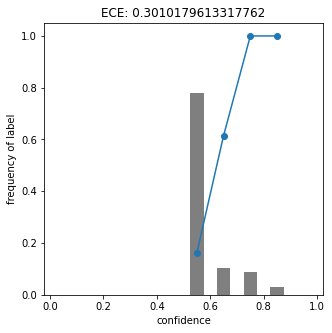

In [171]:
cluster_calibration_plot(np.array(per_cluster_confidence), np.array(per_cluster_label))